From: https://w.wiki/6aKR modified https://w.wiki/6dKb

{'head': {'vars': ['title', 'creatorLabel', 'inception', 'inventory_number', 'made_from_materialLabel', 'image', 'copyright_statusLabel']}, 'results': {'bindings': [{'inventory_number': {'type': 'literal', 'value': 'A III 518'}, 'inception': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '1900-01-01T00:00:00Z'}, 'creatorLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Gotthardt Kuehl'}, 'made_from_materialLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'oil paint'}, 'copyright_statusLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'public domain'}, 'image': {'type': 'uri', 'value': 'http://commons.wikimedia.org/wiki/Special:FilePath/Gotthardt%20Kuehl%20-%20Das%20blaue%20Zimmer%20%28ca.%201900%29.jpg'}, 'title': {'xml:lang': 'de', 'type': 'literal', 'value': 'Das blaue Zimmer'}}, {'inventory_number': {'type': 'literal', 'value': 'A III 518'}, 'inception': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal

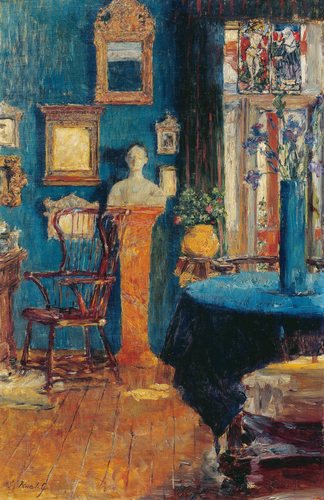




Inventory number: A III 518

Title: Das blaue Zimmer

Creator: Gotthardt Kuehl

Copyright status: public domain



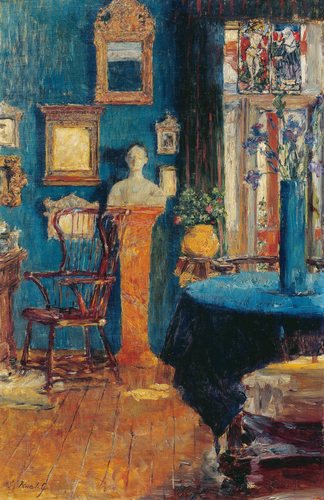




Inventory number: A II 150

Title: Mondschein über der Friedrichsgracht im alten Berlin

Creator: Adolph von Menzel

Copyright status: public domain



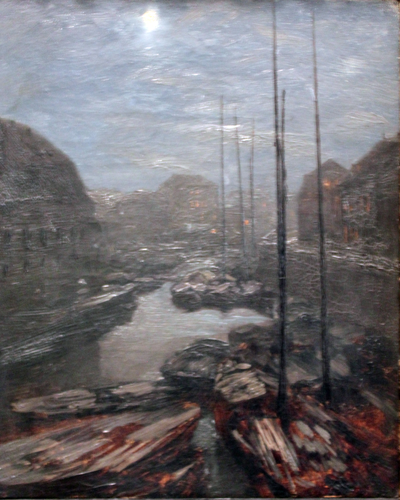




Inventory number: A II 150

Title: Mondschein über der Friedrichsgracht im alten Berlin

Creator: Adolph von Menzel

Copyright status: public domain



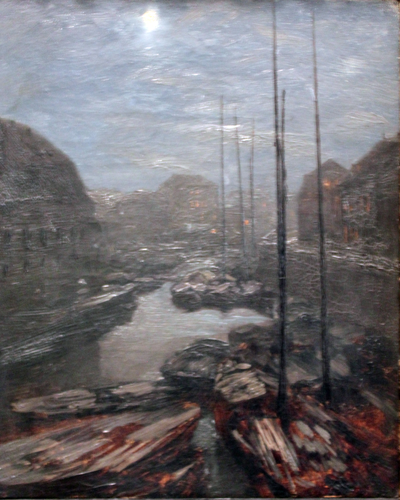




Inventory number: A II 649

Title: Parade in Potsdam im Jahre 1817

Creator: Franz Krüger

Copyright status: public domain



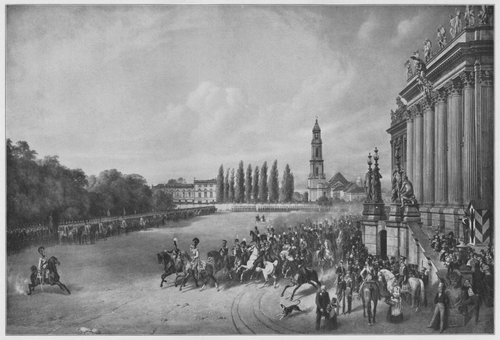




Inventory number: A II 649

Title: Parade in Potsdam im Jahre 1817

Creator: Franz Krüger

Copyright status: public domain



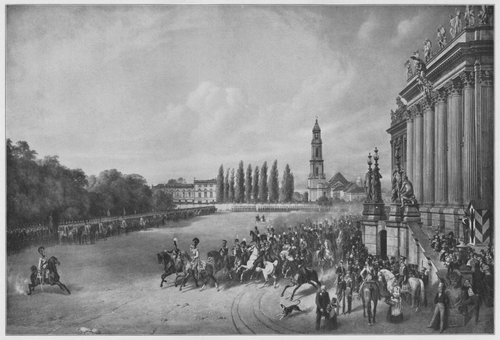




Inventory number: A I 215

Title: Römische Vigna

Creator: Franz Ludwig Catel

Copyright status: public domain



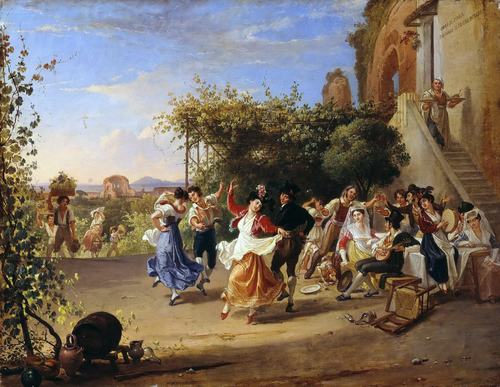




Inventory number: A I 215

Title: Römische Vigna

Creator: Franz Ludwig Catel

Copyright status: public domain



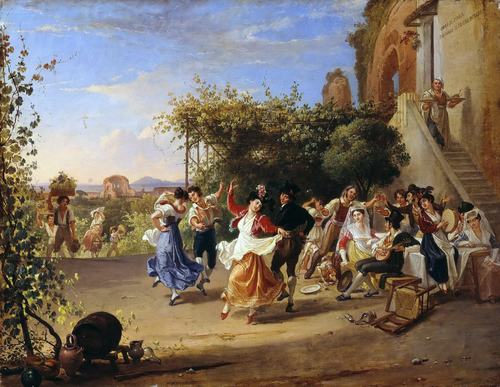




Inventory number: A II 352

Title: Bildnis des Komponisten Carl Maria von Weber

Creator: Caroline Bardua

Copyright status: public domain



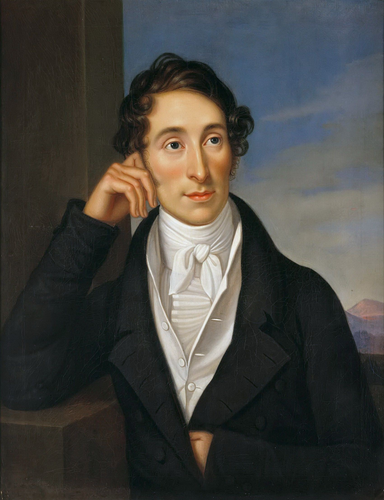

In [9]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

from PIL import Image
import requests

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT ?title ?creatorLabel ?inception ?inventory_number  ?made_from_materialLabel ?image ?copyright_statusLabel  WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?instance_of wdt:P31 wd:Q3305213;
  wdt:P195 wd:Q162111.
  ?instance_of wdt:P18 ?image. 
  ?instance_of wdt:P1476 ?title.
  ?instance_of wdt:P170 ?creator. 
  ?instance_of wdt:P571 ?inception. 
  ?instance_of wdt:P186 ?made_from_material. 
  ?instance_of wdt:P6216 ?copyright_status. 
  ?instance_of wdt:P217 ?inventory_number. 
}
LIMIT 9"""

# SUBROUTINES

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def get_image(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        get_image(url, headers)

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# MAIN PROGRAM

results = get_results(endpoint_url, query)

print(results)

for result in results["results"]["bindings"]:
    if 'inventory_number' in result:
      print('Inventory number: ' + result['inventory_number']['value'] + '\n')
    print('Title: ' + result['title']['value'] + '\n')
    print('Creator: ' + result['creatorLabel']['value'] + '\n')
    if 'copyright_statusLabel' in result:
      print('Copyright status: ' + result['copyright_statusLabel']['value'] + '\n')

    if 'image' in result:
      # get image from image URL and display resized version
      image_url=result['image']['value']
      headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
      im = get_image(image_url, headers)
      im.thumbnail((500, 500), Image.Resampling.LANCZOS)
      display(im)
    print('\n\n')